In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from lightgbm import LGBMClassifier
import joblib

In [2]:
df = pd.read_csv("fraudTrain.csv")
print(f"Shape of dataset: {df.shape}")
print("First 5 rows:\n", df.head())

Shape of dataset: (1296675, 23)
First 5 rows:
    Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gil

In [3]:
# List of columns you want to drop
cols_to_drop = ['Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num']

# Drop only existing columns
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

print("Columns successfully dropped (if existed). Remaining columns:")
print(df.columns)



Columns successfully dropped (if existed). Remaining columns:
Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [4]:
# Check if required columns are present
required_cols = ['trans_date_trans_time', 'dob']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f" Missing columns: {missing_cols}")
else:
    # Convert to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

    # Create age and hour features
    df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour

    # Drop original datetime columns
    df.drop(columns=['trans_date_trans_time', 'dob'], inplace=True)

    # Show result
    print("Successfully created 'age' and 'trans_hour' columns:")
    print(df[['age', 'trans_hour']].head())


Successfully created 'age' and 'trans_hour' columns:
   age  trans_hour
0   31           0
1   41           0
2   57           0
3   52           0
4   33           0


In [5]:
le = LabelEncoder()
label_cols = ['merchant', 'category', 'gender', 'job']
for col in label_cols:
    df[col] = le.fit_transform(df[col].astype(str))
print("Encoded sample data:\n", df[label_cols].head())


Encoded sample data:
    merchant  category  gender  job
0       514         8       0  370
1       241         4       0  428
2       390         0       1  307
3       360         2       1  328
4       297         9       1  116


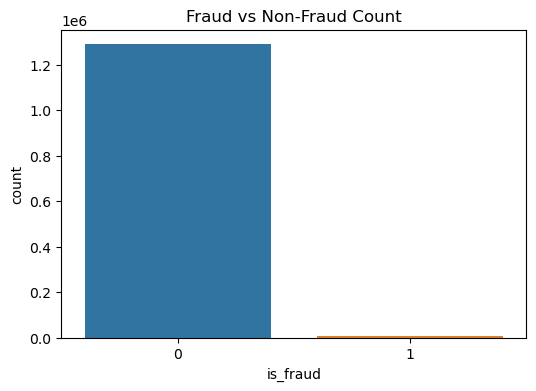

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title("Fraud vs Non-Fraud Count")
plt.show()

In [7]:
fraud = df[df['is_fraud'] == 1]
non_fraud = df[df['is_fraud'] == 0].sample(n=len(fraud), random_state=42)
data = pd.concat([fraud, non_fraud])
print("Balanced dataset shape:", data.shape)
print(data['is_fraud'].value_counts())

X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

Balanced dataset shape: (15012, 15)
is_fraud
1    7506
0    7506
Name: count, dtype: int64


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
print(f"Training size: {X_train.shape[0]} | Testing size: {X_test.shape[0]}")

Training size: 13510 | Testing size: 1502


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


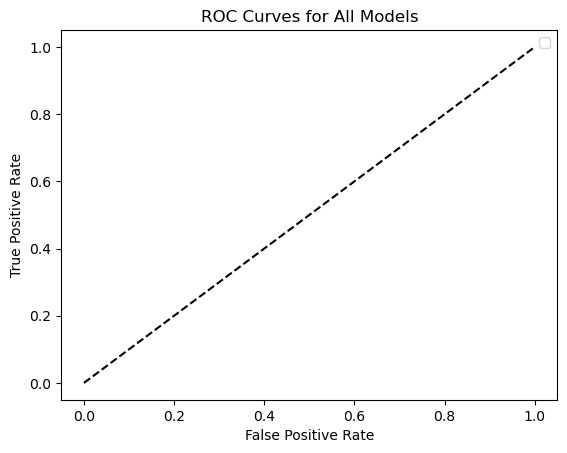

In [10]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()



 Model: Logistic Regression
Confusion Matrix:
 [[707  39]
 [182 574]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.86       746
           1       0.94      0.76      0.84       756

    accuracy                           0.85      1502
   macro avg       0.87      0.85      0.85      1502
weighted avg       0.87      0.85      0.85      1502


 Model: Random Forest
Confusion Matrix:
 [[725  21]
 [ 26 730]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       746
           1       0.97      0.97      0.97       756

    accuracy                           0.97      1502
   macro avg       0.97      0.97      0.97      1502
weighted avg       0.97      0.97      0.97      1502


 Model: SVM
Confusion Matrix:
 [[697  49]
 [125 631]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85     

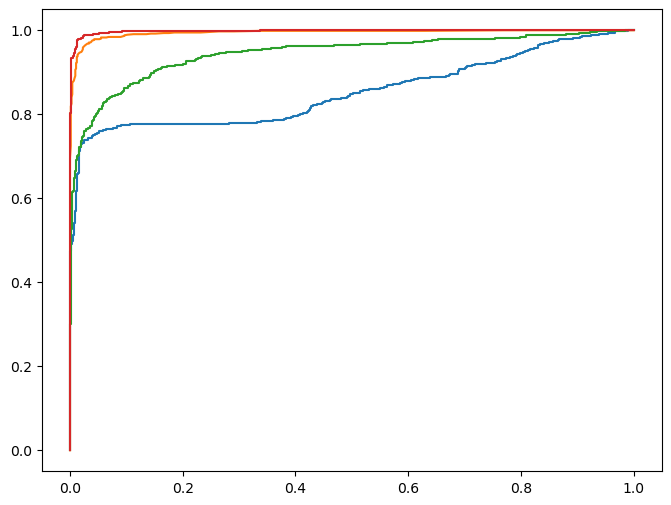

In [11]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05)
}

results = {}
plt.figure(figsize=(8,6))
for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    results[name] = {'Accuracy': acc, 'AUC': auc}

    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")


In [12]:
best_model = models["LightGBM"]
joblib.dump(best_model, "fraud_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("\n Best model saved as 'fraud_model.pkl'")


 Best model saved as 'fraud_model.pkl'


In [13]:
test_df = pd.read_csv("fraudTest.csv")
test_df.drop(columns=['Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num'], inplace=True)
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])
test_df['dob'] = pd.to_datetime(test_df['dob'], errors='coerce')
test_df.dropna(inplace=True)

test_df['age'] = test_df['trans_date_trans_time'].dt.year - test_df['dob'].dt.year
test_df['trans_hour'] = test_df['trans_date_trans_time'].dt.hour
test_df.drop(columns=['trans_date_trans_time', 'dob'], inplace=True)

for col in label_cols:
    test_df[col] = le.fit_transform(test_df[col].astype(str))

if 'is_fraud' in test_df.columns:
    test_df.drop(columns=['is_fraud'], inplace=True)

X_test_final = scaler.transform(test_df)
test_df['prediction'] = best_model.predict(X_test_final)
test_df.to_excel("test_predictions.xlsx", index=False)

print("\n Predictions saved to 'test_predictions.xlsx'")
print("Sample predictions:\n", test_df[['prediction']].value_counts())



 Predictions saved to 'test_predictions.xlsx'
Sample predictions:
 prediction
0             534297
1              21422
Name: count, dtype: int64


In [14]:
fraud_count = test_df[test_df['prediction'] == 1].shape[0]
non_fraud_count = test_df[test_df['prediction'] == 0].shape[0]

print(f"\n Total Transactions Predicted: {len(test_df)}")
print(f"Fraudulent Transactions Detected: {fraud_count}")
print(f"Non-Fraudulent Transactions: {non_fraud_count}")



 Total Transactions Predicted: 555719
Fraudulent Transactions Detected: 21422
Non-Fraudulent Transactions: 534297


In [15]:
# Export only predicted frauds for review
fraud_cases = test_df[test_df['prediction'] == 1]
fraud_cases.to_excel("predicted_fraud_cases.xlsx", index=False)
print("Number of predicted fraud transactions:", len(fraud_cases))
fraud_cases.head()

Number of predicted fraud transactions: 21422


,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,age,trans_hour,prediction
5,30407675418785,126,7,19.55,0,42.1939,-76.7361,520,361,1371816937,41.747157,-77.584197,29,12,1
32,4302475216404898,689,10,19.03,1,42.8511,-93.6200,3032,95,1371817573,42.322809,-94.363655,56,12,1
81,4427805710168,38,7,19.41,0,33.3305,-105.6933,8874,260,1371818385,33.775701,-106.036860,20,12,1
91,30234966027947,599,1,128.33,1,43.9446,-88.0911,5196,76,1371818531,43.051363,-87.799946,42,12,1
101,4400011257587661852,14,5,20.66,0,41.4972,-98.7858,509,299,1371818768,41.103974,-98.484500,40,12,1


In [16]:
for name, metric in results.items():
    print(f"{name} → Accuracy: {metric['Accuracy']:.2f}, AUC: {metric['AUC']:.2f}")

Logistic Regression → Accuracy: 0.85, AUC: 0.85
Random Forest → Accuracy: 0.97, AUC: 0.99
SVM → Accuracy: 0.88, AUC: 0.94
LightGBM → Accuracy: 0.98, AUC: 1.00


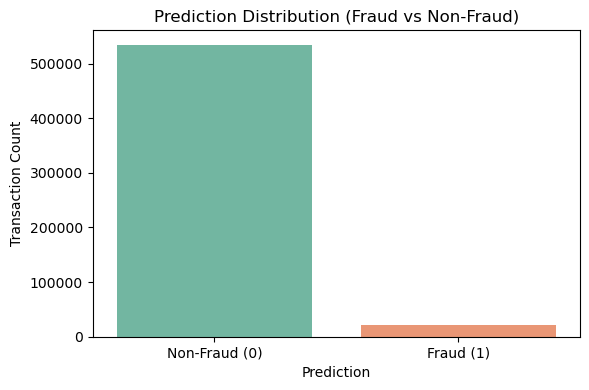

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x='prediction', data=test_df, palette='Set2')
plt.title('Prediction Distribution (Fraud vs Non-Fraud)')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.xlabel('Prediction')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.savefig("fraud_prediction_distribution.png")
plt.show()


Top 5 Transactions by Fraud Probability:
        prediction  fraud_probability
13806            1           0.999952
330173           1           0.999949
261788           1           0.999945
234495           1           0.999945
231616           1           0.999942


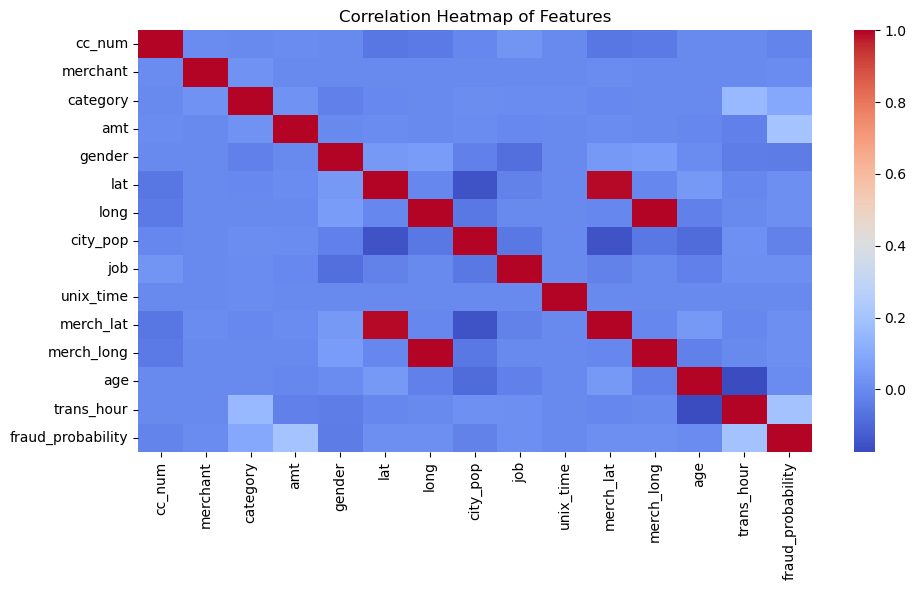

In [18]:
if hasattr(best_model, "predict_proba"):
    test_df['fraud_probability'] = best_model.predict_proba(X_test_final)[:, 1]
    print("\nTop 5 Transactions by Fraud Probability:")
    print(test_df[['prediction', 'fraud_probability']].sort_values(by='fraud_probability', ascending=False).head())

#  Show a heatmap of feature correlations (after encoding)
plt.figure(figsize=(10, 6))
sns.heatmap(test_df.drop(columns=['prediction']).corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png")
plt.show()